In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")

setwd("../")
list.files()

[1] "figures"             "input"               "notebooks"          
[4] "source_data"         "supplemental_tables"

In [2]:
eqtl_path = "supplemental_tables/Table_SX_eQTLs.For_Print.txt"
caqtl_path = "supplemental_tables/Table_SX_caQTLs.For_Print.txt"
haqtl_path = "supplemental_tables/Table_SX_haQTLs.For_Print.txt"

In [10]:
colnames(fread(haqtl_path,sep="\t",data.table=F))

[1] "Tissue"        "Element ID"    "Condition"     "Element Cond" 
 [5] "Element Name"  "Element Chrom" "Element Start" "Element End"  
 [9] "SNP ID"        "SNP Chrom"     "SNP Pos"       "Ref"          
[13] "Alt"           "RSID"          "AF"            "Beta"         
[17] "SE"            "P-value"       "FDR"           "Tests"        
[21] "Q-value"       "Significant"   "Cluster ID"    "Membership"   
[25] "Fetal-Unique"

### Summarize QTLs - Figure 2a,c,d

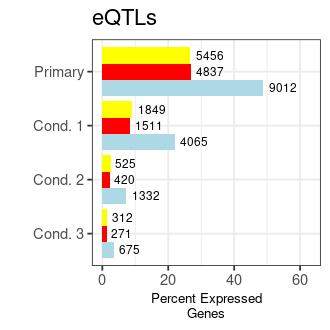

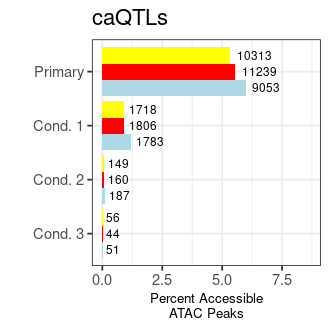

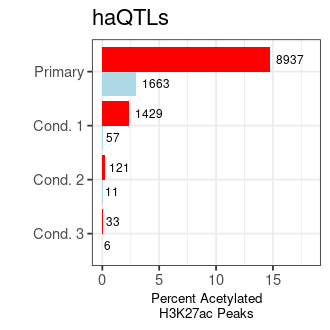

In [336]:
summarize_qtls = function(path, title, xlabel) {
    qtl_df = fread(path, sep="\t",data.table=F)
    qtl_df$QTL = ifelse(qtl_df$Significant == "TRUE", 1,0)
    qtl_summary = unique(qtl_df %>% group_by(Tissue) %>% 
                             mutate(Elements_tested = length(unique(`Element ID`))) %>% 
                            group_by(Tissue,Condition) %>% 
                            mutate(No_QTLs = sum(QTL)) %>% 
                            select(Tissue,Condition,Elements_tested,No_QTLs)) %>% 
                                    mutate(Percent = (No_QTLs/Elements_tested) * 100) %>% 
                                    rename(Cond_numeric = Condition)
    qtl_summary$Condition = ifelse(qtl_summary$Cond_numeric == 0, "Primary",
                                  paste0("Cond. ",qtl_summary$Cond_numeric))
    qtl_summary$Condition = factor(qtl_summary$Condition , levels= rev(c("Primary",paste0("Cond. ",1:3))))
    qtl_summary$Tissue    = factor(qtl_summary$Tissue , levels= c("iPSC","CVPC","PPC"))
    p = ggplot(qtl_summary, aes(Percent, Condition, fill = Tissue)) + theme_bw() +
                ggtitle(title) + ylab("") + xlab(xlabel) +
                xlim(c(0,max(qtl_summary$Percent)+mean(qtl_summary$Percent)+1)) +
                theme(legend.position = "none", axis.title.x = element_text(size=8)) +
                geom_text(aes(label=No_QTLs), position=position_dodge(width=0.9), hjust=-.2, size = 2.5) + 
                geom_bar(stat= "identity", position="dodge") +
                scale_fill_manual(values = c("lightblue", "red", "yellow")) 
    return(p)
    
}

psize(2.75,2.75)
eqtl_summary = summarize_qtls(eqtl_path, "eQTLs", "Percent Expressed\nGenes")
eqtl_summary
caqtl_summary = summarize_qtls(caqtl_path, "caQTLs", "Percent Accessible\nATAC Peaks")
caqtl_summary
haqtl_summary = summarize_qtls(haqtl_path, "haQTLs", "Percent Acetylated\nH3K27ac Peaks")
haqtl_summary


### Map distance - Figure 2b,d,f

In [76]:
ipsc_topsnp_path="input/figure2/iPSC_PP1_SNPs.bed"
cvpc_topsnp_path="input/figure2/CVPC_PP1_SNPs.bed"
ppc_topsnp_path="input/figure2/PPC_PP1_SNPs.bed"

In [88]:
ipsc_topsnp_df = fread(ipsc_topsnp_path, sep="\t",data.table=F)
ipsc_topsnp_df$Tissue = "iPSC"

cvpc_topsnp_df = fread(cvpc_topsnp_path, sep="\t",data.table=F)
cvpc_topsnp_df$Tissue = "CVPC"

ppc_topsnp_df = fread(ppc_topsnp_path, sep="\t",data.table=F)
ppc_topsnp_df$Tissue = "PPC"
top_snps = as.data.frame(rbindlist(list(ipsc_topsnp_df,
                                       cvpc_topsnp_df,
                                       ppc_topsnp_df))) %>%
                            rename(`SNP Chromsome` = V1, `SNP Start` = V2, `SNP End` = V3,
                                  `SNP PP` = V4, `Element Cond` = V5)


In [114]:
process_qtls = function(qtl_path) {
    qtl_df = fread(qtl_path,sep="\t",data.table=F) %>% 
                    filter(Significant == "TRUE") %>% 
                    select(Tissue, `Element ID`, Condition, `Element Cond`, 
                           `Element Chrom`,`Element Start`,`Element End`)
    return(qtl_df)
}

all_qtls = as.data.frame(rbindlist(list(process_qtls(eqtl_path),
                          process_qtls(caqtl_path),
                          process_qtls(haqtl_path))))

gencode = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)[,4:5] %>% 
                rename(Strand = strand, `Element ID` = gene_id)

all_qtls = merge(all_qtls, gencode[ gencode$`Element ID` %in% all_qtls$`Element ID`,],all=TRUE,by="Element ID")

In [338]:
nrow(fread(caqtl_path, sep="\t",data.table=F) %>% filter(Significant == "TRUE"))

[1] 36559

In [117]:
all_qtl_snps = merge(all_qtls, top_snps, by=c("Tissue","Element Cond"))


In [120]:
all_qtl_snps$test_start = ifelse(grepl("^E",all_qtl_snps$`Element ID`) & all_qtl_snps$Strand == "+", 
                                 all_qtl_snps$`Element Start`-1000, 
                                ifelse(grepl("^E",all_qtl_snps$`Element ID`) & all_qtl_snps$Strand == "-", 
                                      all_qtl_snps$`Element End`-1000, all_qtl_snps$`Element Start`))

all_qtl_snps$test_end = ifelse(grepl("^E",all_qtl_snps$`Element ID`) & all_qtl_snps$Strand == "+", 
                                 all_qtl_snps$`Element Start`+1000, 
                                ifelse(grepl("^E",all_qtl_snps$`Element ID`) & all_qtl_snps$Strand == "-", 
                                      all_qtl_snps$`Element End`+1000, all_qtl_snps$`Element End`))


In [137]:
calculate_min_distance = function(df) {

  distances = numeric(nrow(df))

  for (i in 1:nrow(df)) {
    position = df$`SNP End`[i]
    start = df$test_start[i]
    end = df$test_end[i]

    if (position >= start && position <= end) {
      distances[i] = 0
    } else {
      distances[i] = min(abs(position - start), abs(position - end))
    }
  }


    df$min_distance = distances
    df = unique(df %>% group_by(Tissue,`Element ID`,Condition) %>% 
        summarise(Tissue = Tissue, `Element ID` = `Element ID`, Condition = Condition, Closest = min(min_distance)))
  return(df)
}

In [145]:
snp_distances = calculate_min_distance(all_qtl_snps)


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Tissue', 'Element ID', 'Condition'. You
can override using the `.groups` argument.


In [146]:
snp_distances$Annotation =  ifelse(snp_distances$Closest == 0 & grepl("^E",snp_distances$`Element ID`), "In TSS Window",
                            ifelse(snp_distances$Closest == 0 ,   "In Peak",
                            ifelse(snp_distances$Closest < 1000 ,  "0-1kb",
                            ifelse(snp_distances$Closest < 5000 , "1-5kb",
                            ifelse(snp_distances$Closest < 10000 , "5-10kb",
                            ifelse(snp_distances$Closest < 25000 , "10-25kb",
                            ifelse(snp_distances$Closest < 50000 , "25-50kb",
                            ifelse(snp_distances$Closest < 100000 , "50-100kb",
                            ifelse(snp_distances$Closest < 250000 , "100-250kb",
                            ifelse(snp_distances$Closest < 500000 , "250-500kb",">500kb"))))))))))

In [151]:
snp_distances$Cond = ifelse(snp_distances$Condition == 0,"Primary",paste0("Cond. ",snp_distances$Condition))
snp_distances$Cond = factor(snp_distances$Cond, levels = c("Primary",paste0("Cond. ",1:3)))
snp_distances$Tissue = factor(snp_distances$Tissue, levels = c("iPSC","CVPC","PPC"))

In [316]:
fwrite(snp_distances,"input/figure3/finemap_snp_distances.txt",sep="\t",row.names=F, quote=F)

In [153]:
eqtl_distances = snp_distances[ grepl("^E",snp_distances$`Element ID`),]
caqtl_distances = snp_distances[ grepl("atac",snp_distances$`Element ID`),]
haqtl_distances = snp_distances[ grepl("chip",snp_distances$`Element ID`),]


Tissue,Element ID,Condition,Closest,Annotation,Cond
<fct>,<chr>,<int>,<dbl>,<chr>,<fct>
CVPC,ENSG00000001036.14,0,17437,10-25kb,Primary
CVPC,ENSG00000001561.7,0,0,In TSS Window,Primary
CVPC,ENSG00000001561.7,1,30019,25-50kb,Cond. 1
CVPC,ENSG00000002016.18,0,856092,>500kb,Primary
CVPC,ENSG00000002016.18,1,856092,>500kb,Cond. 1
CVPC,ENSG00000002016.18,2,856092,>500kb,Cond. 2


In [414]:
nrow(haqtl_distances[ haqtl_distances$Annotation %in% c("In Peak") & haqtl_distances$Cond == "Primary",])/nrow(haqtl_distances[haqtl_distances$Cond == "Primary",])
tmp = unique(eqtl_distances %>%  group_by(Cond,Tissue,Annotation) %>% 
                                    mutate(n_qtls = n()) %>% 
                                    group_by(Cond) %>% 
                                      mutate(Percent = (n_qtls/n())*100) %>% 
                                    select(Tissue, Cond,Annotation, n_qtls,Percent))

tmp [ tmp$Annotation == "In TSS Window",]

[1] 0.4739965

Tissue,Cond,Annotation,n_qtls,Percent
<fct>,<fct>,<chr>,<int>,<dbl>
CVPC,Primary,In TSS Window,942,6.2616325
CVPC,Cond. 1,In TSS Window,74,1.3136872
CVPC,Cond. 2,In TSS Window,12,0.6900518
CVPC,Cond. 3,In TSS Window,2,0.2002002
PPC,Primary,In TSS Window,833,5.5370912
PPC,Cond. 1,In TSS Window,69,1.2249246
PPC,Cond. 2,In TSS Window,13,0.7475561
PPC,Cond. 3,In TSS Window,1,0.1001001
iPSC,Primary,In TSS Window,1739,11.5594257


In [402]:
distance_plot = function(distance_df, datatype, xlabel, ylabel) {
    dist_summary = unique(distance_df %>%  group_by(Cond,Tissue,Annotation) %>% 
                                    mutate(n_qtls = n()) %>% 
                                    group_by(Cond) %>% 
                                      mutate(Percent = (n_qtls/n())*100) %>% 
                                    select(Tissue, Cond,Annotation, n_qtls,Percent))
                                    
    if (datatype == "eqtl") {
        dist_summary$Annotation = factor(dist_summary$Annotation,
                                        levels = c('In TSS Window','0-1kb','1-5kb','5-10kb','10-25kb','25-50kb',
                                                   '50-100kb','100-250kb','250-500kb','>500kb'))
        p = ggplot(dist_summary, aes(Annotation,Percent, fill=Tissue)) + theme_bw() +
                    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=6),
                         axis.title.x = element_text(size=8), axis.title.y = element_text(size=8)) +
                    xlab(xlabel) + ylab(ylabel) +
                    geom_bar(stat="identity") + facet_wrap(~Cond, nrow = 1) +
                    scale_fill_manual(values=c("lightblue","red","yellow"))
    } else {
        dist_summary$Annotation = factor(dist_summary$Annotation,
                                        levels = c('In Peak','0-1kb','1-5kb','5-10kb','10-25kb','25-50kb',
                                                   '50-100kb'))
        p = ggplot(dist_summary, aes(Annotation,Percent, fill=Tissue)) + theme_bw() +
                    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,size=8),
                         axis.title.x = element_text(size=8), axis.title.y = element_text(size=8)) +
                    xlab(xlabel) + ylab(ylabel) +
                    geom_bar(stat="identity") + facet_wrap(~Cond, nrow = 1) +
                    scale_fill_manual(values=c("lightblue","red","yellow"))
    }

    return(p)
}

psize(2.5,5)


b = distance_plot(eqtl_distances, "eqtl","Lead Variant Distance from eGene TSS Window","Percent of eQTLs\n(By Condition)")
d = distance_plot(caqtl_distances, "caqtl","Lead Variant Distance from caPeak","Percent of caQTLs\n(By Condition)")
f = distance_plot(haqtl_distances[ haqtl_distances$Annotation != "100-250kb",],
                              "haqtl","Lead Variant Distance from haPeak","Percent ofhaQTLs\n(By Condition)")



### QTL Chromatin State Enrichment - Figure 2g 

In [181]:
### download ES-derived cardiomyocyte states 
#### wget https://personal.broadinstitute.org/cboix/epimap/ChromHMM/observed_aux_18_hg38/CALLS/BSS00171_18_CALLS_segments.bed.gz

### download iPSC-18a
#### wget https://personal.broadinstitute.org/cboix/epimap/ChromHMM/observed_aux_18_hg38/CALLS/BSS00737_18_CALLS_segments.bed.gz

In [182]:
cvpc_states = fread("input/figure2/BSS00171_18_CALLS_segments.bed.gz",sep="\t",data.table=F)
ipsc_states = fread("input/figure2/BSS00737_18_CALLS_segments.bed.gz",sep="\t",data.table=F)

In [188]:
collapse_states = function(state_df) {
    state_df$state [ state_df$V4 %in% c("EnhA1","EnhA2","EnhG1","EnhG2","EnhWk","EnhBiv")] = "Enhancer"
    state_df$state [ state_df$V4 %in% c("Tx","TxWk")] = "Transcribed"
    state_df$state [ state_df$V4 %in% c("Quies")] = "Quiescent"
    state_df$state [ state_df$V4 %in% c("ReprPC","ReprPCWk","Het","ZNF/Rpts")] = "Repressed"
    state_df$state [ state_df$V4 %in% c("TssA","TssBiv","TssFlnkU","TssFlnkD","TssFlnk")] = "Promoter"
    state_df = state_df[ state_df$V1 %in% paste0("chr",1:22),]
    state_df = state_df[ order(state_df$V1, state_df$V2, state_df$V3),]
    return(state_df[, c(1:3,10)])
}

fwrite(collapse_states(cvpc_states),"input/figure2/cvpc_states.bed",sep="\t",row.names=F,col.names=F)
fwrite(collapse_states(ipsc_states),"input/figure2/ipsc_states.bed",sep="\t",row.names=F,col.names=F)

In [206]:
read_all_tests = function(qtl_path, tissue, datatype) {
    qtl_df          = fread(qtl_path,sep="\t",data.table=F) %>% 
                            filter(Tissue == tissue) %>% 
                            mutate(start = `SNP Pos` - 1 ) %>% 
                            select(`SNP Chrom`,start,`SNP Pos`,`Element Cond`,Tissue, `Significant`) 
    qtl_df$datatype = datatype
    return(qtl_df)
}

fwrite(as.data.frame(rbindlist(list(read_all_tests(eqtl_path, "iPSC","eQTL"),
                                        read_all_tests(caqtl_path, "iPSC","caQTL"),
                                        read_all_tests(haqtl_path, "iPSC","haQTL")))) %>%
                            arrange(`SNP Chrom`,start,`SNP Pos`),
       "input/figure2/ipsc_lead.bed",sep="\t",row.names=F,quote=F,col.names=F)

fwrite(as.data.frame(rbindlist(list(read_all_tests(eqtl_path, "CVPC","eQTL"),
                                        read_all_tests(caqtl_path, "CVPC","caQTL"),
                                        read_all_tests(haqtl_path, "CVPC","haQTL")))) %>%
                            arrange(`SNP Chrom`,start,`SNP Pos`),
       "input/figure2/cvpc_lead.bed",sep="\t",row.names=F,quote=F,col.names=F)

In [210]:
ipsc_state_path = "input/figure2/ipsc_states.bed"
ipsc_lead_path  = "input/figure2/ipsc_lead.bed"
ipsc_command = paste("bedtools", "intersect", "-a", ipsc_state_path,
                     "-b", ipsc_lead_path, "-wb",
                     "> input/figure2/ipsc_lead_state_annots.bed")

cvpc_state_path = "input/figure2/cvpc_states.bed"
cvpc_lead_path  = "input/figure2/cvpc_lead.bed"
cvpc_command = paste("bedtools", "intersect", "-a", cvpc_state_path,
                     "-b", cvpc_lead_path, "-wb",
                     "> input/figure2/cvpc_lead_state_annots.bed")
message(cvpc_command)


bedtools intersect -a input/figure2/cvpc_states.bed -b input/figure2/cvpc_lead.bed -wb > input/figure2/cvpc_lead_state_annots.bed



In [211]:
state_annotations = rbind(fread("input/figure2/ipsc_lead_state_annots.bed",sep="\t",data.table=F),
                          fread("input/figure2/cvpc_lead_state_annots.bed",sep="\t",data.table=F))


In [387]:
state_table = as.data.frame(table(state_annotations$V11, state_annotations$V4, state_annotations$V10))

chromstate_enrich = function(state, type) {
    totest = state_table[ state_table$Var1 == type,]
    x11 = totest$Freq[ totest$Var2 == state     & totest$Var3 == "TRUE"]
    x12 = totest$Freq[ totest$Var2 == state     & totest$Var3 == "FALSE"]
    x21 = sum(totest$Freq[ totest$Var2 != state & totest$Var3 == "TRUE"])
    x22 = sum(totest$Freq[ totest$Var2 != state & totest$Var3 == "FALSE"])
    
    fish = fisher.test(matrix(c(x11,x12,x21,x22),nrow=2))
    out = data.frame(State = as.character(state), QTL = type,
                     `Odds Ratio` = fish$estimate, LowerCI = fish$conf.int[1],
                     UpperCI = fish$conf.int[2],Pvalue = fish$p.value)
    return(out)
}

atac_enrich = as.data.frame(rbindlist(lapply(unique(state_table$Var2),chromstate_enrich, type ="caQTL")))
chip_enrich = as.data.frame(rbindlist(lapply(unique(state_table$Var2),chromstate_enrich, type ="haQTL")))
rna_enrich  = as.data.frame(rbindlist(lapply(unique(state_table$Var2),chromstate_enrich, type ="eQTL")))


state_enrich_out = as.data.frame(rbindlist(list(rna_enrich,atac_enrich,chip_enrich)))
state_enrich_out$`QTL Type` = factor(state_enrich_out$QTL , levels = rev(c("haQTL","caQTL","eQTL")))
state_enrich_out$State = factor(state_enrich_out$State, levels=rev(c("Promoter","Enhancer","Transcribed",
                                                                 "Repressed","Quiescent")))

state_enrich_out$`log2(OR)` = log2(state_enrich_out$Odds.Ratio)
state_enrich_out$log2Low = log2(state_enrich_out$LowerCI)
state_enrich_out$log2Hi = log2(state_enrich_out$UpperCI)
state_enrich_out$significant = ifelse(state_enrich_out$Pvalue > 0.05, "FALSE","TRUE")
psize(2.5,3.5)
g= ggplot(state_enrich_out, aes(`log2(OR)`, State, color = `QTL Type`, group=`QTL Type`, shape=significant)) + theme_bw() +
    xlim(c(-1,1.55))+ ylab("") + xlab("Chromatin State\nEnrichment (log2(OR))") +
    theme(axis.text = element_text(size=12),
         axis.title = element_text(size=12))  +
    geom_point(na.rm=TRUE, position=position_dodge(width=0.75),size=1.5) +
    geom_vline(xintercept = 0,lty =2 ) +
    geom_linerange(aes(x=`log2(OR)`, xmin=log2Low, xmax=log2Hi), 
                  na.rm=TRUE, position=position_dodge(width=0.75)) +
    scale_color_manual(values = c("orange","brown","lightBlue")) + 
    geom_hline(yintercept = 1.5, color = "lightgrey") +
    geom_hline(yintercept = 2.5, color = "lightgrey") +
    geom_hline(yintercept = 3.5, color = "lightgrey") +
    geom_hline(yintercept = 4.5, color = "lightgrey") +
    scale_shape_manual(values = c(1, 16), guide = "none") 

In [419]:
state_enrich_out[ state_enrich_out$QTL == "haQTL",]

,State,QTL,Odds.Ratio,LowerCI,UpperCI,Pvalue,QTL Type,log2(OR),log2Low,log2Hi,significant
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<chr>
11,Enhancer,haQTL,1.8362661,1.7288822,1.9490681,1.038651e-79,haQTL,0.8767751,0.789839580,0.9627845,TRUE
12,Promoter,haQTL,1.2221828,1.1070122,1.3469895,7.265498e-05,haQTL,0.2894601,0.146671157,0.4297386,TRUE
13,Quiescent,haQTL,1.0317612,0.9932243,1.0718641,1.069866e-01,haQTL,0.0451091,-0.009808554,0.1001220,FALSE
14,Repressed,haQTL,0.5704042,0.5187804,0.6260291,2.819290e-37,haQTL,-0.8099434,-0.946804166,-0.6756985,TRUE
15,Transcribed,haQTL,0.8125832,0.7759532,0.8507066,1.578034e-19,haQTL,-0.2994126,-0.365958371,-0.2332664,TRUE


### caPeak-haPeak overlap - Figure 2h

In [246]:
make_peak_beds = function(qtl_path) {
    qtl_df  = fread(qtl_path,sep="\t",data.table=F) %>% filter(Tissue == "CVPC")
    sig_peaks = qtl_df$`Element ID`[ qtl_df$Significant == "TRUE"]
    qtl_bed = unique(qtl_df %>% 
                select(`Element Chrom`, `Element Start`, `Element End`, `Element ID`) %>%
                mutate(Significant = `Element ID` %in% sig_peaks ) %>%
                arrange(`Element Chrom`, `Element Start`, `Element End`)) 
    
    
    return(qtl_bed)
}
fwrite(make_peak_beds(caqtl_path),
       "input/figure2/cvpc_capeak.bed",sep="\t",row.names=F,col.names=F,quote=F)

fwrite(make_peak_beds(haqtl_path),
       "input/figure2/cvpc_hapeak.bed",sep="\t",row.names=F,col.names=F,quote=F)

In [352]:
peak_int_command = paste("bedtools", "intersect", "-a", "input/figure2/cvpc_capeak.bed",
                     "-b", "input/figure2/cvpc_hapeak.bed", "-loj",
                     "> input/figure2/cvpc_capeak_hapeak.bed")
message(peak_int_command)

caha = fread("input/figure2/cvpc_capeak_hapeak.bed",sep="\t",data.table=F)
caha$Annotation = ifelse(caha$V5 == "TRUE" & caha$V10 == "TRUE", "caPeak-haPeak",
                        ifelse(caha$V5 == "TRUE", "caPeak","No QTL"))
table(caha$Annotation)

bedtools intersect -a input/figure2/cvpc_capeak.bed -b input/figure2/cvpc_hapeak.bed -loj > input/figure2/cvpc_capeak_hapeak.bed




       caPeak caPeak-haPeak        No QTL 
         8721          2715        194385 

In [353]:
atac_bed = make_peak_beds(caqtl_path)

atac_bed$Annotation = ifelse(atac_bed$`Element ID` %in% caha$V4[ caha$Annotation == "caPeak-haPeak"], "caPeak-haPeak",
                            ifelse(atac_bed$`Element ID` %in% caha$V4[ caha$Annotation == "caPeak"], "caPeak","No QTL"))
atac_bed = atac_bed %>% select(`Element ID`, Annotation) %>% rename(PeakID = `Element ID`)

In [ ]:
cvpc_gene_express = readRDS("/projects/CARDIPS/analysis/epigenome_resource/eqtls/CVPC/step_4/qtl_by_element/qtl_input.rds")$phenotype_info
gencode = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)
cvpc_gene_express2 = merge(cvpc_gene_express, gencode[,5:6], by.x="element_id",by.y="gene_id")

In [377]:
### load JASPAR predictions

jaspar      = unique(fread("input/figure1/CVPC_JAPSAR_TOBIAS.txt",sep="\t",data.table=F)[,1:2])
jaspar$TFBS = toupper(gsub("_MA.*","",jaspar$MotifID))
jaspar$occur = 1 

jaspar_expressed = jaspar[ jaspar$TFBS %in% cvpc_gene_express2$gene_name,]
length(unique(jaspar_expressed$TFBS))
jaspar_cast = reshape2::dcast(PeakID ~ TFBS, data= jaspar_expressed,value.var = "occur",fun.aggregate = sum)
# head(jaspar)

[1] 444

In [378]:
atac_tfbs = merge(atac_bed, jaspar_cast[ jaspar_cast$PeakID %in% atac_bed$PeakID,], all=TRUE)
atac_tfbs[ is.na(atac_tfbs)] = 0 

In [421]:
tmp = atac_tfbs[rowSums(data.matrix(atac_tfbs[,3:ncol(atac_tfbs)])) > 0,]
table(tmp$Annotation)


       caPeak caPeak-haPeak        No QTL 
         2593          1641         51035 

In [380]:
property = colnames(atac_tfbs)[3:ncol(atac_tfbs)]
calculate_enrichment = function(property, vertices){
        totest          = vertices[, c(property, "Annotation")]

        colnames(totest) = c("property", "annot")

        annots = names(table(totest$annot))
    
        tests = as.data.frame(rbindlist(lapply(annots, function(annot){
            x11  = nrow(totest[ totest$property == 1 & totest$annot == annot, ])
            x12  = nrow(totest[ totest$property == 1 & totest$annot != annot, ])
            x21  = nrow(totest[ totest$property == 0 & totest$annot == annot, ])
            x22  = nrow(totest[ totest$property == 0 & totest$annot != annot, ])
            mat  = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
            test = fisher.test(mat)
            out  = data.frame(TF = property, Annotation = annot, 
                              x11 = x11, x12 = x12, x21 = x21, x22 = x22, estimate = test$estimate, 
                              ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value)
            return(out)
        })), stringsAsFactors = FALSE)
        return(tests)}

enrich = function(x, annot){
        tests       = as.data.frame(rbindlist(lapply(1:length(property), 
                                                     function(ii){calculate_enrichment(property[ii], x)})))
        tests       = tests
        tests$padj  = p.adjust(tests$pval, method = "BH")
        tests$log2r = log2(tests$estimate)
        return(tests)}


In [381]:
atac_tfbs_enrich = enrich(atac_tfbs[rowSums(data.matrix(atac_tfbs[,3:ncol(atac_tfbs)])) > 0,])


In [382]:
atac_tfbs_enrich2 = atac_tfbs_enrich[ atac_tfbs_enrich$TF %in% cvpc_gene_express2$gene_name, ]
atac_tfbs_enrich2[ atac_tfbs_enrich2$TF == "CTCF",]


,TF,Annotation,x11,x12,x21,x22,estimate,ci1,ci2,pval,padj,log2r
,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
109,CTCF,caPeak,815,16275,1778,36401,1.025245,0.9405381,1.1167979,5.715266e-01,7.674128e-01,0.03596888
110,CTCF,caPeak-haPeak,280,16810,1361,36818,0.450607,0.3942886,0.5135223,1.788535e-38,2.382328e-35,-1.15005852
111,CTCF,No QTL,15995,1095,35040,3139,1.308590,1.2180649,1.4065717,5.618292e-14,1.870891e-11,0.38801276


In [389]:
top_tfs = atac_tfbs_enrich[  atac_tfbs_enrich$estimate > 1 & atac_tfbs_enrich$padj < 0.05,] %>% 
                                group_by(Annotation) %>%
                                top_n(10, log2r)

top_tfs = c(top_tfs$TF,"GATA4")

atac_tfbs_enrich2 = atac_tfbs_enrich[ atac_tfbs_enrich$TF %in% top_tfs, ]
atac_tfbs_enrich2$'log2(OR)' = ifelse(atac_tfbs_enrich2$padj < 0.05, atac_tfbs_enrich2$log2r, 0)
atac_tfbs_enrich2$'log2(OR)'[ atac_tfbs_enrich2$'log2(OR)' < -0.75 ] = -0.75
atac_tfbs_enrich2$'log2(OR)'[ atac_tfbs_enrich2$'log2(OR)' > 0.75 ] = 0.75
atac_tfbs_enrich2$Annotation = factor(atac_tfbs_enrich2$Annotation ,
                                      levels = rev(c("caPeak","caPeak-haPeak","No QTL")))


atac_tfbs_enrich2_cast = reshape2::dcast(TF ~ Annotation, data = atac_tfbs_enrich2,
                                         fun.aggregate = mean, value.var = "log2(OR)")
rownames(atac_tfbs_enrich2_cast) = atac_tfbs_enrich2_cast$TF
atac_tfbs_enrich2_cast$TF = NULL

ord <- hclust( dist(atac_tfbs_enrich2_cast, method = "euclidean"), method = "ward.D" )$order

atac_tfbs_enrich2$TF2 = factor(atac_tfbs_enrich2$TF, levels = rev(rownames(atac_tfbs_enrich2_cast[ord,])))
psize(2,4)

# psize(5,2.5)
h = ggplot(atac_tfbs_enrich2, aes(TF2, Annotation,  fill= `log2(OR)`)) + theme_bw()+
  geom_tile(color = "black")  +  xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
         legend.position ="bottom") +
  scale_fill_gradient2(low="blue",mid = "white", high="red") 

### Figure 2

In [395]:
psize(2.25*4,7.5)
png("figures/Figure2.png",res=300,units="in",width=7.5,height=9)
plot_grid(plot_grid(eqtl_summary,b,rel_widths = c(0.4,1), labels=c("a","b")),
          plot_grid(caqtl_summary,d,rel_widths = c(0.4,1), labels=c("c","d")),
          plot_grid(haqtl_summary,f,rel_widths = c(0.4,1), labels=c("e","f")),
          plot_grid(g,h,nrow=1,rel_widths = c(0.9,1),labels=c("g","h")),nrow=4)
dev.off()

png 
  2

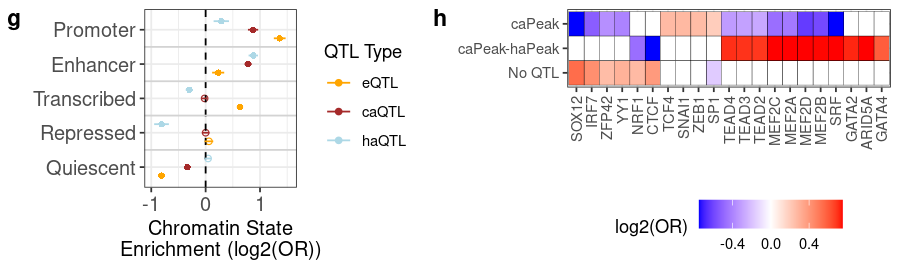

In [393]:
psize(2.25,7.5)
plot_grid(g,h,nrow=1,rel_widths = c(0.9,1),labels=c("g","h"))